Reference notebook: https://github.com/NVIDIA-Merlin/NVTabular/blob/main/examples/01-Getting-started.ipynb

## (1) Download the dataset

In [1]:
import os
import dotenv
dotenv.load_dotenv(".env")

True

In [2]:
from merlin.datasets.entertainment import get_movielens

In [ ]:
input_path = os.environ.get("INPUT_DATA_DIR", os.path.expanduser("~/merlin-framework/movielens/"))
get_movielens(variant="ml-1m", path=input_path);

In [4]:
ls {input_path}/ml-1m #noqa

README                    ratings.dat               users.dat
movies.dat                train.parquet             users_converted.parquet
movies_converted.parquet  transformed/              valid.parquet


In [5]:
from merlin.core.dispatch import get_lib

train = get_lib().read_parquet(f'{input_path}/ml-1m/train.parquet')
valid = get_lib().read_parquet(f'{input_path}/ml-1m/valid.parquet')

In [6]:
train.head()

,userId,movieId,rating,timestamp
271838,1643,2729,4,995610410
348252,2041,52,4,1004131663
445769,2749,1272,5,983468699
482072,2962,2940,5,977246612
302813,1798,1035,4,974756919


## (2) Processing the dataset with NVTabular

In [7]:
import nvtabular as nvt
from merlin.schema.tags import Tags

train_ds = nvt.Dataset(train)
valid_ds = nvt.Dataset(valid)

train_ds, valid_ds

/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/io/dataset.py:251: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


(<merlin.io.dataset.Dataset at 0x2a9e3b5b0>,
 <merlin.io.dataset.Dataset at 0x2af54c910>)

In [8]:
"""categorify to make sure they are continuous integers,"""
output = ['userId', 'movieId'] >> nvt.ops.Categorify()

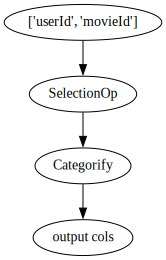

In [9]:
output.graph




Let us also add our target to the set of returned columns.

Additionally, we tag the rating column with appropriate tags. This will allow other components of the Merlin Framework to use this information and minimize the code we will have to write to perform complex operations such as training or serving a Deep Learning model.

If you would like to learn more about using Tags, take a look at the NVTabular
and Merlin Models integrated example notebook in the Merlin Models repository.
https://nvidia-merlin.github.io/models/main/examples/02-Merlin-Models-and-NVTabular-integration.html


In [10]:
"""add tag to rating column"""
output += ['rating'] >> nvt.ops.AddMetadata(tags=[Tags.REGRESSION, Tags.TARGET])

In [11]:
workflow = nvt.Workflow(output)

### Applying the workflow to the train and validation sets

In [12]:
workflow.fit_transform(train_ds).to_parquet('train')
workflow.transform(valid_ds).to_parquet('valid')

/Users/nelsonlin/miniforge3/envs/tensorflow/lib/python3.8/site-packages/merlin/io/dataset.py:251: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [13]:
train_transformed = nvt.Dataset('train', engine='parquet')
valid_transformed = nvt.Dataset('valid', engine='parquet')

In [14]:
train_transformed.head()

,userId,movieId,rating
0,1245,1442,4
1,276,769,4
2,3156,462,5
3,230,1955,5
4,3729,259,4


### (3) Modeling

In [15]:
import tensorflow
import merlin.models.tf as mm

2022-12-17 22:06:29.369080: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-17 22:06:29.369777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [16]:
train_transformed.schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.freq_threshold,properties.start_index,properties.max_size,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name
0,userId,(Tags.CATEGORICAL),int64,False,False,NaN,6041.0,210.0,0.0,0.0,0.0,.//categories/unique.userId.parquet,0.0,6040.0,userId
1,movieId,(Tags.CATEGORICAL),int64,False,False,NaN,3672.0,159.0,0.0,0.0,0.0,.//categories/unique.movieId.parquet,0.0,3671.0,movieId
2,rating,"(Tags.TARGET, Tags.REGRESSION)",int64,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
model = mm.DLRMModel(
    train_transformed.schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.RegressionTask('rating')
)

In [18]:
opt = tensorflow.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt)

In [ ]:
model.fit(train_transformed, validation_data=valid_transformed, batch_size=1024, epochs=5)

In [20]:
model.optimizer.learning_rate = 1e-4
metrics = model.fit(train_transformed, validation_data=valid_transformed, batch_size=1024, epochs=3)

Epoch 1/3
782/782 [==============================] - 14s 17ms/step - loss: 0.2816 - root_mean_squared_error: 0.5306 - regularization_loss: 0.0000e+00 - loss_batch: 0.2813 - val_loss: 0.9677 - val_root_mean_squared_error: 0.9837 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 1.0311
Epoch 2/3
782/782 [==============================] - 13s 17ms/step - loss: 0.2689 - root_mean_squared_error: 0.5185 - regularization_loss: 0.0000e+00 - loss_batch: 0.2686 - val_loss: 0.9838 - val_root_mean_squared_error: 0.9919 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 1.0542
Epoch 3/3
782/782 [==============================] - 13s 16ms/step - loss: 0.2608 - root_mean_squared_error: 0.5107 - regularization_loss: 0.0000e+00 - loss_batch: 0.2606 - val_loss: 1.0006 - val_root_mean_squared_error: 1.0003 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 1.0762


### 4) Inference

In [24]:
predictions = model.predict(valid_transformed,batch_size = 64)

2022-12-17 22:11:30.936557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [28]:
valid_transformed.head()

,userId,movieId,rating
0,1270,451,3
1,134,1858,4
2,1309,626,3
3,1484,627,4
4,419,423,5


In [26]:
predictions

array([[2.5554368],
       [4.6113815],
       [3.0808837],
       ...,
       [3.7482548],
       [3.9042666],
       [4.4439774]], dtype=float32)